## Drifting orientation decoding

In [1]:
from dataset import *

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarn

In [2]:
drifting_presentations = get_stimulus_presentations(stimulus_name="drifting_gratings")
print(f"Found {len(drifting_presentations)} drifting gratings presentations")

units = get_units()
print(f"Found {len(units)} units total")

spike_data = get_conditionwise_spike_statistics(stimulus_name="drifting_gratings")
print(f"Spike statistics shape: {spike_data.shape}")

Found 630 drifting gratings presentations
Found 902 units total
Spike statistics shape: (36982, 5)


In [3]:
print("Spike data is a MultiIndex pd Dataframe, with the unit_id + stimulus_condition_id as indices and the following columns:")
spike_data.columns

Spike data is a MultiIndex pd Dataframe, with the unit_id + stimulus_condition_id as indices and the following columns:


Index(['spike_count', 'stimulus_presentation_count', 'spike_mean', 'spike_std',
       'spike_sem'],
      dtype='object')

In [4]:
# take the unit_id as index
spike_data = spike_data.reset_index("unit_id")

In [5]:
# map orientation from stimulus presentations to spike data
drifting_presentations_unique = drifting_presentations.reset_index().set_index('stimulus_condition_id')
orientation_map = drifting_presentations_unique['orientation'].to_dict()

In [6]:
# add orientation to spike data
spike_data['orientation'] = spike_data.index.get_level_values('stimulus_condition_id').map(orientation_map)
spike_data.head()

,unit_id,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,orientation
stimulus_condition_id,,,,,,,
246,951805352,110,15,7.333333,5.802298,1.498147,180.0
246,951805369,104,15,6.933333,4.350151,1.123204,180.0
246,951805392,159,15,10.600000,8.192331,2.115251,180.0
246,951805411,103,15,6.866667,8.683866,2.242164,180.0
246,951805440,94,15,6.266667,5.063407,1.307366,180.0


In [7]:
print("Before:", spike_data['orientation'].unique())
spike_data['orientation'] = spike_data['orientation'].replace('null', np.nan)

spike_data_clean = spike_data.dropna(subset=['orientation'])
print(f"Clean spike data shape: {spike_data_clean.shape}")
print("After:", spike_data_clean['orientation'].unique())

Before: [180.0 225.0 135.0 0.0 315.0 90.0 270.0 'null' 45.0]
Clean spike data shape: (36080, 7)
After: [180. 225. 135.   0. 315.  90. 270.  45.]


Note that we have 8 different orientations available for drifting gratings with a 45 degree difference (instead of 30) making a full circle. As with drifting gratings the direction matters as well.

## Filtering by Orientation Selectivity Index (OSI)

### Calculation
For each neuron, compute its tuning curve (mean firing rate across trials for each orientation). Use:

OSI= (R_preferred - R_orthogonal)/(R_preferred + R_orthogonal)


Justification: Neurons with high OSI (>0.5) are sharply tuned to specific orientations and are critical for encoding orientation information.

In [8]:
# Create tuning curves
tuning_curves = spike_data_clean.groupby(['unit_id', 'orientation']).spike_count.mean().unstack()
print(f"Tuning curves shape: {tuning_curves.shape}")
tuning_curves

Tuning curves shape: (902, 8)


orientation,0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0
unit_id,,,,,,,,
951805352,107.0,122.0,105.6,146.0,152.0,113.8,103.6,140.6
951805369,110.6,126.2,114.4,111.0,128.8,117.0,113.8,112.8
951805392,195.8,214.4,168.8,185.2,168.8,148.6,138.2,191.0
951805411,155.0,162.0,151.8,151.6,141.8,179.0,159.6,187.8
951805440,49.2,50.2,55.4,56.2,64.0,46.4,36.6,51.6
...,...,...,...,...,...,...,...,...
951827752,141.8,122.8,194.0,101.4,81.2,86.8,197.0,173.8
951827758,14.6,16.4,37.0,23.2,12.2,37.6,88.6,34.4
951827774,1.0,16.0,6.0,2.8,2.2,14.8,1.8,7.2


In [9]:
# Find preferred and orthogonal orientations
preferred_orientation = tuning_curves.idxmax(axis=1)
R_pref = tuning_curves.max(axis=1)
R_orth = tuning_curves.apply(lambda x: x[(x.idxmax() + 90) % 360], axis=1) #360 here as we wrap around the whole circle

In [10]:
R_pref.head()

unit_id
951805352    152.0
951805369    128.8
951805392    214.4
951805411    187.8
951805440     64.0
dtype: float64

In [11]:
R_orth.head()

unit_id
951805352    103.6
951805369    113.8
951805392    185.2
951805411    162.0
951805440     36.6
dtype: float64

In [12]:
# Calculate OSI
OSI = (R_pref - R_orth) / (R_pref + R_orth + 1e-6)  

print("OSI values:", OSI.sort_values(ascending=False).head())

OSI values: unit_id
951816866    1.000000
951815365    0.989341
951815212    0.988463
951815256    0.970007
951815237    0.963878
dtype: float64


Note very high OSI values for units when presented with drifting gratings. One unit 951816866 even achieving 1 meaning it is only activated when the grating moves in its preferred direction.

As well as OSI for drifting gratings we can investigate DSI (Direction Selectivity Index) to capture the directional preference of neurons by looking the tuning curves when orientation is 180 degrees apart.

DSI = (R_preferred - R_opposite) / (R_preferred + R_opposite)

In [13]:
preferred_direction = tuning_curves.idxmax(axis=1)
R_pref = tuning_curves.max(axis=1)
opposite_direction = (preferred_direction + 180) % 360
R_opp = tuning_curves.lookup(tuning_curves.index, opposite_direction)

In [14]:
DSI = (R_pref - R_opp) / (R_pref + R_opp)
print("DSI values:", DSI.sort_values(ascending=False).head())

DSI values: unit_id
951815924    0.742529
951817007    0.739130
951826348    0.730337
951818039    0.626523
951811322    0.615385
dtype: float64


### ANOVA

"Do neurons, as a population, respond differently to different orientations of drifting gratings?"

Null Hypothesis (H₀): All orientations elicit the same mean spike count (no tuning).

Alternative Hypothesis (H₁): At least one orientation elicits a significantly different mean spike count (tuning exists).

In [15]:
# Perform ANOVA for each unit
p_values = spike_data_clean.groupby('unit_id').apply(
    lambda x: f_oneway(*[group.spike_count for name, group in x.groupby('orientation')])[1]
)

print(f"Number of units with significant orientation tuning (p<0.05): {(p_values < 0.05).sum()}")

Number of units with significant orientation tuning (p<0.05): 257


Adding region information and selecting well tuned units.

In [16]:
unit_regions = get_units()['ecephys_structure_acronym']

tuning_curves_with_regions = pd.merge(
    unit_regions.rename('ecephys_structure_acronym'),
    tuning_curves,          
    on="unit_id",        
    how="inner"       
)

tuning_curves_with_regions.head()

,ecephys_structure_acronym,0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0
unit_id,,,,,,,,,
951817231,grey,475.2,434.2,507.8,475.6,370.4,451.8,508.6,453.2
951817222,grey,90.8,101.8,127.6,73.2,115.8,93.4,93.0,121.6
951817272,grey,762.2,768.6,769.2,782.8,764.2,778.2,762.6,759.8
951817282,grey,225.8,231.6,237.0,262.0,236.6,253.2,267.6,251.6
951817316,grey,335.0,342.2,332.6,366.6,292.2,312.8,324.0,349.0


In [17]:
# Select highly tuned neurons (high OSI and statistically significant)
filtered_neurons = OSI[(OSI > 0.5) & (p_values < 0.05)].index
selected_neurons = tuning_curves_with_regions.loc[filtered_neurons]
selected_neurons_list = selected_neurons.index.unique()

print(f"Number of orientation-selective neurons: {len(selected_neurons)}")
print("\nDistribution across brain regions:")
print(selected_neurons.groupby("ecephys_structure_acronym").size().sort_values(ascending=False))

Number of orientation-selective neurons: 81

Distribution across brain regions:
ecephys_structure_acronym
VISal    28
VISp     19
VISam    14
VISl      9
VISrl     9
VISpm     1
grey      1
dtype: int64


In [18]:
# Select highly tuned neurons (high DSI and statistically significant)
filtered_neurons_DSI = DSI[(DSI > 0.5) & (p_values < 0.05)].index
selected_neurons_DSI = tuning_curves_with_regions.loc[filtered_neurons_DSI]
selected_neurons_list_DSI = selected_neurons_DSI.index.unique()

print(f"Number of orientation-selective neurons: {len(selected_neurons_DSI)}")
print("\nDistribution across brain regions:")
print(selected_neurons_DSI.groupby("ecephys_structure_acronym").size().sort_values(ascending=False))

Number of orientation-selective neurons: 8

Distribution across brain regions:
ecephys_structure_acronym
VISal    2
VISp     2
VISrl    2
VISl     1
grey     1
dtype: int64


Well tuned selection using OSI>0.5 and ANOVA p-value < 0.05 reveales 81 well-tuned units for drifting gratings, approx. double static.

Using DSI>0.5 and ANOVA p-value < 0.05 reveales only 8 units.

## Visualisation of tuning curves

Note a similar distribution across regions to static gratings.

In [19]:
# Melt orientation columns into rows

vis_df = selected_neurons.reset_index()
melted_df = pd.melt(
    vis_df,
    id_vars=["unit_id", "ecephys_structure_acronym"],
    value_vars=[0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0],
    var_name="orientation",
    value_name="spike_count"
)

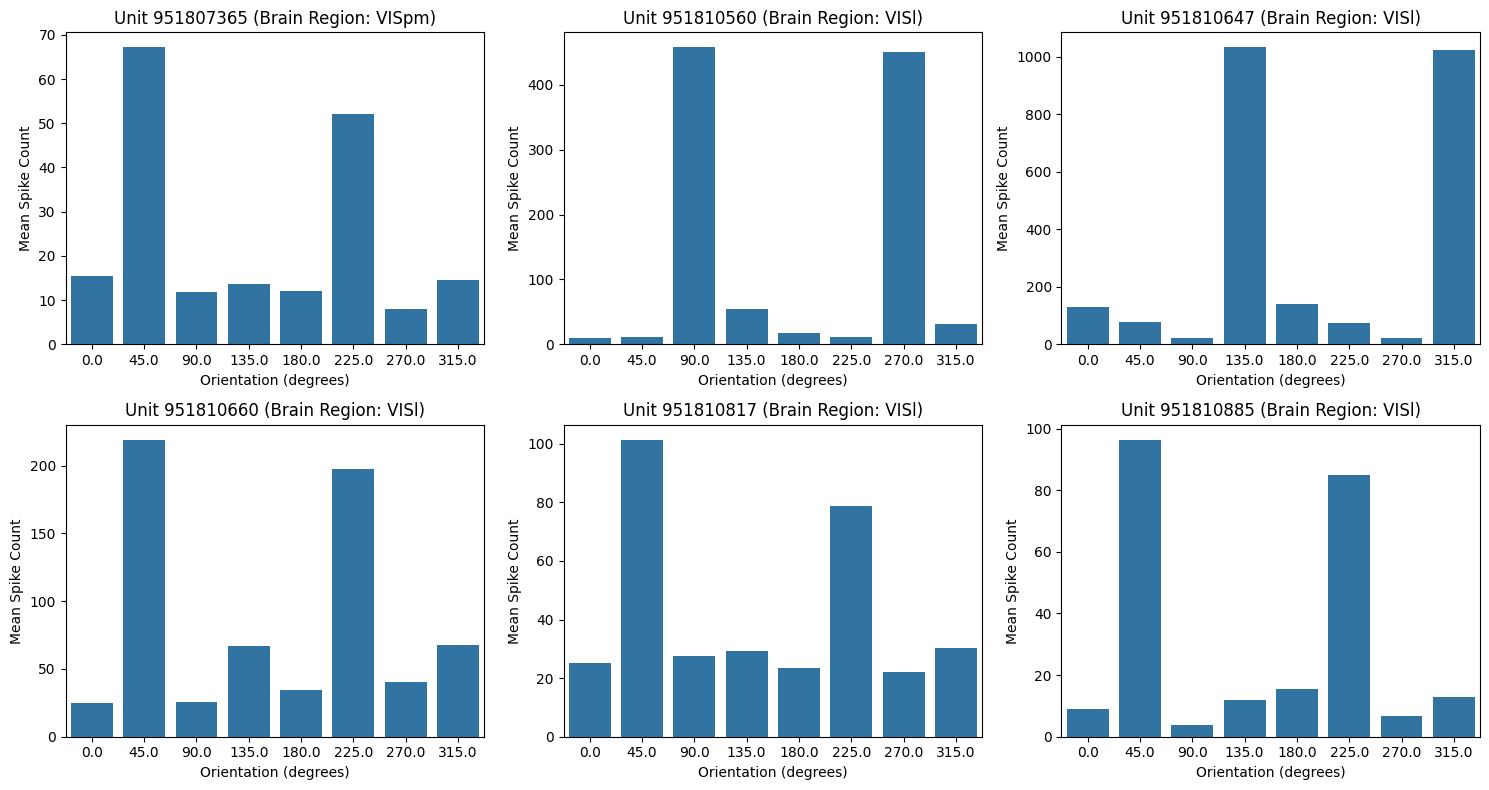

In [20]:
unit_ids = melted_df["unit_id"].unique()[:6]

fig, axes = plt.subplots(2, 3, figsize=(15,8))

axes = axes.flatten()

for i, unit_id in enumerate(unit_ids):
    # Filter data for the current neuron
    neuron_data = melted_df[melted_df["unit_id"] == unit_id]

    ax = axes[i]
    sns.barplot(
        data=neuron_data,
        x="orientation",
        y="spike_count",
        order=[0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0],
        ax=ax
    )
    
    brain_region = neuron_data["ecephys_structure_acronym"].iloc[0]
    ax.set_title(f"Unit {unit_id} (Brain Region: {brain_region})", fontsize=12)
    ax.set_xlabel("Orientation (degrees)", fontsize=10)
    ax.set_ylabel("Mean Spike Count", fontsize=10)
    
plt.tight_layout()
plt.show()

These plots convey why there were far fewer units satisfying DSI > 0.5 than OSI > 0.5. Interestingly unit activation seems to be far more dependent on the orientation than the direction.

# Building the Classifier

## Preparing the Dataset

In [21]:
selected_data = spike_data_clean[spike_data_clean['unit_id'].isin(selected_neurons_list)]

In [22]:
# Create features (X) and target (y)
X = selected_data.pivot_table(
    index='stimulus_condition_id', 
    columns='unit_id', 
    values='spike_count',
    fill_value=0
)

# Get corresponding orientations for each stimulus condition
y = selected_data.groupby('stimulus_condition_id')['orientation'].first()

In [23]:
# Check the distribution of orientations
orientation_counts = y.value_counts()
print("Orientation distribution:")
print(orientation_counts)

Orientation distribution:
180.0    5
225.0    5
135.0    5
0.0      5
315.0    5
90.0     5
270.0    5
45.0     5
Name: orientation, dtype: int64


Limitation: We only have 5 presentations per orientation for drifting gratings.

In [24]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)

In [26]:
# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Random Forest Accuracy:")
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
        45.0       1.00      1.00      1.00         1
        90.0       1.00      0.50      0.67         2
       135.0       1.00      1.00      1.00         2
       180.0       1.00      1.00      1.00         2
       225.0       1.00      1.00      1.00         1
       270.0       0.67      1.00      0.80         2
       315.0       1.00      1.00      1.00         1

    accuracy                           0.92        12
   macro avg       0.96      0.94      0.93        12
weighted avg       0.94      0.92      0.91        12

Random Forest Accuracy:
0.9166666666666666


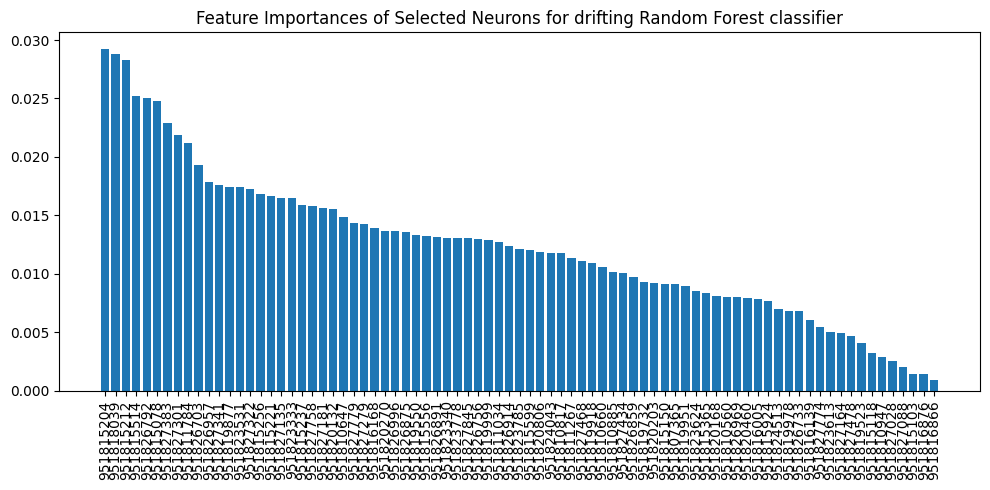

In [27]:
# Plot feature importances to see which neurons contribute most
plt.figure(figsize=(10, 5))
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importances of Selected Neurons for drifting Random Forest classifier')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

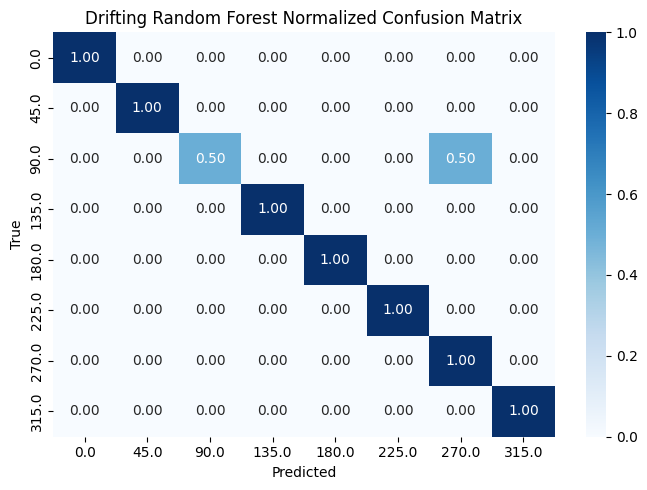

In [28]:
# Visualize classifier performance with a heatmap
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Drifting Random Forest Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

SVM Accuracy: 1.0000
Logistic Regression Accuracy: 1.0000


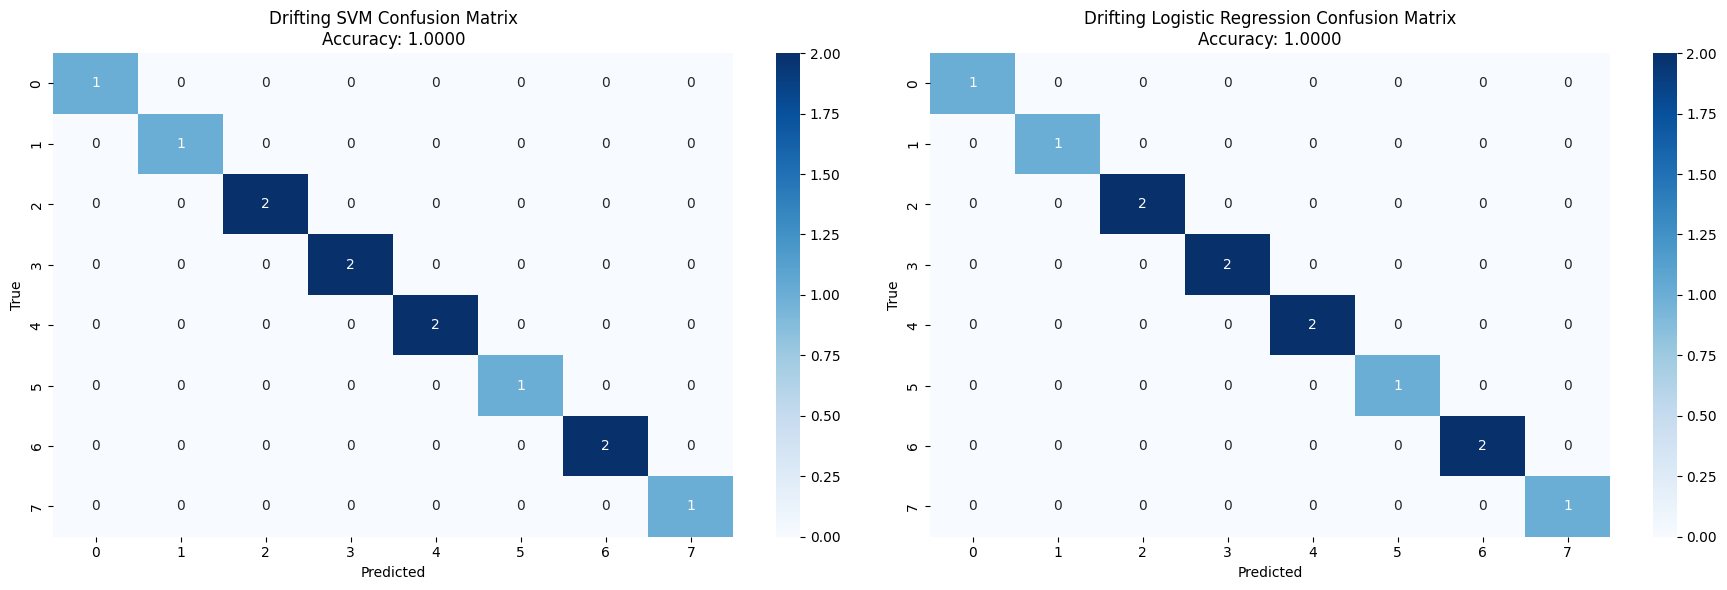

In [29]:
# Support Vector Machine
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

# Multinomial Logistic Regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

# Visualize confusion matrices
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Drifting SVM Confusion Matrix\nAccuracy: {accuracy_svm:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title(f'Drifting Logistic Regression Confusion Matrix\nAccuracy: {accuracy_lr:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()